# GNNTrajectory: visualize and compare checkpoints

Quickly plot predictions vs. ground truth on a small set of example scenarios (e.g., the sample scenes under `notebooks/data`). Two plots per scenario:
- **2s models (4 ckpts)** overlaid
- **GAT-MLP 1s vs 2s** overlaid


## Environment
1. Activate your environment (e.g., `conda activate av2`).
2. From the repo root, install:
   ```bash
   pip install -e .
   pip install -r requirements.txt
   ```
3. Optionally set `AV2_ROOT` env var; otherwise defaults to `./notebooks/data`.


In [7]:
# Install in the current environment (uncomment if needed)
# !pip install -e .
# !pip install -r requirements.txt

In [8]:

from pathlib import Path
import os
import sys
import torch

# Resolve repo root (walk up to .git)
def _find_repo_root(start: Path) -> Path:
    p = start
    for _ in range(6):
        if (p / ".git").exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return start

REPO_ROOT = _find_repo_root(Path.cwd())
SRC_ROOT = REPO_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))  # allow `import gnn_trajectory`
DEFAULT_AV2_ROOT = REPO_ROOT / "notebooks" / "data"

# --- User configuration -------------------------------------------------
AV2_ROOT = Path(os.environ.get("AV2_ROOT", DEFAULT_AV2_ROOT))  # dataset folder containing scenario dirs
SPLIT = ""  # empty -> use AV2_ROOT directly
INDICES = []   # optional explicit scenario indices to visualize; empty uses START_IDX/NUM_EXAMPLES
START_IDX = 0  # starting scenario index when INDICES is empty
NUM_EXAMPLES = 10 # how many scenarios to show, starting at START_IDX (ignored if INDICES is set)
MODEL_GROUP = "both"  # options: "2sec", "gat-mlp", "both"
SCENE_LIMIT = None  # optional cap on number of scenarios (None = no cap)

CKPTS_2SEC = [
    REPO_ROOT / "src/gnn_trajectory/checkpoints/ckpt_2sec_gat-lstm.pt",
    REPO_ROOT / "src/gnn_trajectory/checkpoints/ckpt_2sec_gat-mlp.pt",
    REPO_ROOT / "src/gnn_trajectory/checkpoints/ckpt_2sec_gcn_v2-lstm.pt",
    REPO_ROOT / "src/gnn_trajectory/checkpoints/ckpt_2sec_gcn_v2-mlp.pt",
]
CKPTS_GAT_MLP = [
    REPO_ROOT / "src/gnn_trajectory/checkpoints/ckpt_1sec_gat-mlp.pt",
    REPO_ROOT / "src/gnn_trajectory/checkpoints/ckpt_2sec_gat-mlp.pt",
]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FOCAL_ONLY = True
SEPARATE = True
# -----------------------------------------------------------------------

if not AV2_ROOT.exists():
    raise FileNotFoundError(f"Set AV2_ROOT to your AV2 dataset path (got {AV2_ROOT})")
for path_list in [CKPTS_2SEC, CKPTS_GAT_MLP]:
    for p_ckpt in path_list:
        if not p_ckpt.exists():
            raise FileNotFoundError(f"Checkpoint not found: {p_ckpt}")
print(f"Repo root: {REPO_ROOT}")
print(f"AV2 root:  {AV2_ROOT}")
print(f"Device:    {DEVICE}")


Repo root: /home/arian-sumak/code/DTU/GNNTrajectory
AV2 root:  /home/arian-sumak/code/DTU/GNNTrajectory/notebooks/data
Device:    cpu


In [9]:
import numpy as np
from gnn_trajectory.config import ExperimentConfig
from gnn_trajectory.data import AV2GNNForecastingDataset
from gnn_trajectory.models.motion_estimation_model import collate_fn as motion_collate_fn
from gnn_trajectory.visualize_predictions import (
    build_model,
    load_checkpoint,
    load_config_from_checkpoint,
    visualize_with_prediction,
)

# Collect scenarios directly from AV2_ROOT (no full dataset download needed)
SCENE_DIRS = sorted([p for p in AV2_ROOT.iterdir() if p.is_dir()])
if not SCENE_DIRS:
    raise FileNotFoundError(f"No scenario folders found under {AV2_ROOT}")
print(f"Found {len(SCENE_DIRS)} scenarios under {AV2_ROOT}")

ALL_CKPTS = CKPTS_2SEC + CKPTS_GAT_MLP

# Base config (match visualize_predictions.py logic)
base_cfg = ExperimentConfig()
base_cfg.data.root = AV2_ROOT
base_cfg.data.split = SPLIT

ckpt_cfgs = []
max_fut_sec = base_cfg.data.fut_seconds
for p in ALL_CKPTS:
    cfg_ckpt = load_config_from_checkpoint(p)
    ckpt_cfgs.append(cfg_ckpt)
    if cfg_ckpt is None:
        print(f"[warn] {p.name} does not contain a config; will fall back to base config")
    else:
        print(
            f"[ckpt] {p.name}: obs={cfg_ckpt.data.obs_seconds}s fut={cfg_ckpt.data.fut_seconds}s "
            f"hz={cfg_ckpt.data.frequency_hz} max_agents={cfg_ckpt.data.max_agents}"
        )
        max_fut_sec = max(max_fut_sec, cfg_ckpt.data.fut_seconds)

CKPT_CFG_MAP = {str(p): cfg for p, cfg in zip(ALL_CKPTS, ckpt_cfgs)}

# Extend fut_seconds to the longest across checkpoints (full GT horizon)
base_cfg.data.fut_seconds = max_fut_sec
base_cfg.materialize_model_config()
print(
    f"Dataset cfg -> obs={base_cfg.data.obs_seconds}s fut={base_cfg.data.fut_seconds}s "
    f"hz={base_cfg.data.frequency_hz} max_agents={base_cfg.data.max_agents}"
)

# Dataset restricted to the local scenarios
dataset_kwargs = dict(
    root=base_cfg.data.root,
    split=base_cfg.data.split,
    obs_sec=base_cfg.data.obs_seconds,
    fut_sec=base_cfg.data.fut_seconds,
    hz=base_cfg.data.frequency_hz,
    max_agents=base_cfg.data.max_agents,
    max_lanes=base_cfg.data.max_lanes,
    max_pts=base_cfg.data.max_lane_points,
    agent_radius=base_cfg.data.agent_radius,
    knn_lanes=base_cfg.data.lane_knn,
)
print("Loading dataset…")
ds = AV2GNNForecastingDataset(**dataset_kwargs)
print(
    f"Dataset: scenarios={len(ds)} obs_sec={base_cfg.data.obs_seconds} "
    f"fut_sec={base_cfg.data.fut_seconds} hz={base_cfg.data.frequency_hz}"
)

# Quick sanity check on horizon using the first sample (helps catch GT truncation)
sample0 = ds[0]
fut_steps = sample0["fut_mask"].shape[1]
fut_sec_actual = fut_steps / base_cfg.data.frequency_hz
print(f"Sanity: dataset fut_mask length = {fut_steps} steps (~{fut_sec_actual:.2f}s)")


Found 27 scenarios under /home/arian-sumak/code/DTU/GNNTrajectory/notebooks/data
[ckpt] ckpt_2sec_gat-lstm.pt: obs=9.0s fut=2.0s hz=10.0 max_agents=128
[ckpt] ckpt_2sec_gat-mlp.pt: obs=9.0s fut=2.0s hz=10.0 max_agents=128
[ckpt] ckpt_2sec_gcn_v2-lstm.pt: obs=9.0s fut=2.0s hz=10.0 max_agents=128
[ckpt] ckpt_2sec_gcn_v2-mlp.pt: obs=9.0s fut=2.0s hz=10.0 max_agents=128
[ckpt] ckpt_1sec_gat-mlp.pt: obs=10.0s fut=1.0s hz=10.0 max_agents=128
[ckpt] ckpt_2sec_gat-mlp.pt: obs=9.0s fut=2.0s hz=10.0 max_agents=128
Dataset cfg -> obs=7.0s fut=4.0s hz=10.0 max_agents=128
Loading dataset…
Dataset: scenarios=27 obs_sec=7.0 fut_sec=4.0 hz=10.0
Sanity: dataset fut_mask length = 40 steps (~4.00s)


In [10]:
def load_models(paths):
    models = []
    for p in paths:
        cfg_ckpt = CKPT_CFG_MAP.get(str(p))
        if cfg_ckpt is None:
            cfg_ckpt = ExperimentConfig.from_dict(base_cfg.to_dict())
            cfg_note = "(using base config)"
        else:
            cfg_note = "(config from checkpoint)"

        # warn if data shapes differ from dataset config (obs/fut/hz etc.)
        mismatches = []
        for field in [
            "obs_seconds",
            "fut_seconds",
            "frequency_hz",
            "max_agents",
            "max_lanes",
            "max_lane_points",
        ]:
            base_val = getattr(base_cfg.data, field)
            ckpt_val = getattr(cfg_ckpt.data, field)
            if base_val != ckpt_val:
                mismatches.append(f"{field}: dataset={base_val} ckpt={ckpt_val}")
        if mismatches:
            print(f"[warn] data config mismatch for {p.name} vs dataset: " + "; ".join(mismatches))

        model_cfg = cfg_ckpt.materialize_model_config()
        model = build_model(cfg_ckpt, DEVICE)
        load_checkpoint(model, p, DEVICE)
        model.eval()
        models.append((p.stem, model))
        print(f"Loaded {p.name} {cfg_note}")
    return models

models_2sec = load_models(CKPTS_2SEC)
models_gat_mlp = load_models(CKPTS_GAT_MLP)


[warn] data config mismatch for ckpt_2sec_gat-lstm.pt vs dataset: obs_seconds: dataset=7.0 ckpt=9.0; fut_seconds: dataset=4.0 ckpt=2.0
[checkpoint] loaded from /home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/checkpoints/ckpt_2sec_gat-lstm.pt
Loaded ckpt_2sec_gat-lstm.pt (config from checkpoint)
[warn] data config mismatch for ckpt_2sec_gat-mlp.pt vs dataset: obs_seconds: dataset=7.0 ckpt=9.0; fut_seconds: dataset=4.0 ckpt=2.0
[checkpoint] loaded from /home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/checkpoints/ckpt_2sec_gat-mlp.pt
Loaded ckpt_2sec_gat-mlp.pt (config from checkpoint)
[warn] data config mismatch for ckpt_2sec_gcn_v2-lstm.pt vs dataset: obs_seconds: dataset=7.0 ckpt=9.0; fut_seconds: dataset=4.0 ckpt=2.0
[checkpoint] loaded from /home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/checkpoints/ckpt_2sec_gcn_v2-lstm.pt
Loaded ckpt_2sec_gcn_v2-lstm.pt (config from checkpoint)
[warn] data config mismatch for ckpt_2sec_gcn_v2-mlp.pt vs dataset: ob

In [11]:

def summarize(sample):
    A = int(sample["num_agents"])
    L = int(sample["num_lanes"])
    fut_mask = sample["fut_mask"][:A]
    fut_len = fut_mask.shape[1]
    fut_sec = fut_len / base_cfg.data.frequency_hz
    focal_idx = np.argmin(np.linalg.norm(sample["agent_hist"][:A, -1, :2], axis=1))
    focal_horizon = int(fut_mask[focal_idx].sum())
    print(
        f"Scenario {sample['scenario_id']} | agents={A} lanes={L} | "
        f"focal horizon={focal_horizon}/{fut_len} steps (~{fut_sec:.2f}s)"
    )


def visualize_idx(idx: int, models, title_suffix: str):
    sample = ds[idx]
    summarize(sample)
    batch = motion_collate_fn([sample])
    batch_device = {k: (v.to(DEVICE) if torch.is_tensor(v) else v) for k, v in batch.items()}

    preds_by_label = {}
    for label, model in models:
        with torch.no_grad():
            pred_traj, focal_idx = model(batch_device)
        preds_by_label[label] = pred_traj[0].cpu().numpy()
        print(f"{label}: pred shape={tuple(pred_traj.shape)}, focal_idx={int(focal_idx[0])}")

    visualize_with_prediction(
        sample,
        preds_by_label,
        separate=SEPARATE,
        focal_only=FOCAL_ONLY,
        hz=base_cfg.data.frequency_hz,
    )


Planning to show indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] (max available: 27)

=== Scenario 0 ===
Scenario 00a0ec58-1fb9-4a2b-bfd7-f4e5da7a9eff | agents=14 lanes=63 | focal horizon=40/40 steps (~4.00s)

--- 2s models (4 ckpts) ---
Scenario 00a0ec58-1fb9-4a2b-bfd7-f4e5da7a9eff | agents=14 lanes=63 | focal horizon=40/40 steps (~4.00s)
ckpt_2sec_gat-lstm: pred shape=(1, 20, 2), focal_idx=4
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=4
ckpt_2sec_gcn_v2-lstm: pred shape=(1, 20, 2), focal_idx=4
ckpt_2sec_gcn_v2-mlp: pred shape=(1, 20, 2), focal_idx=4


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


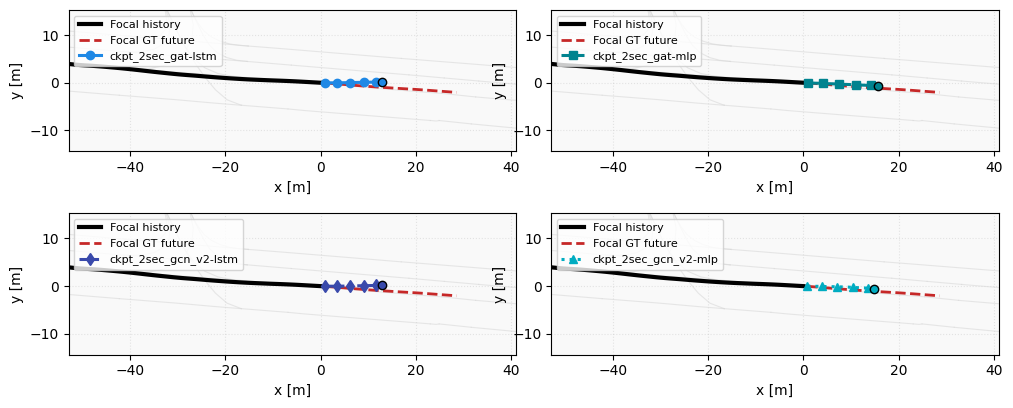


--- GAT-MLP 1s vs 2s ---
Scenario 00a0ec58-1fb9-4a2b-bfd7-f4e5da7a9eff | agents=14 lanes=63 | focal horizon=40/40 steps (~4.00s)
ckpt_1sec_gat-mlp: pred shape=(1, 10, 2), focal_idx=4
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=4


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


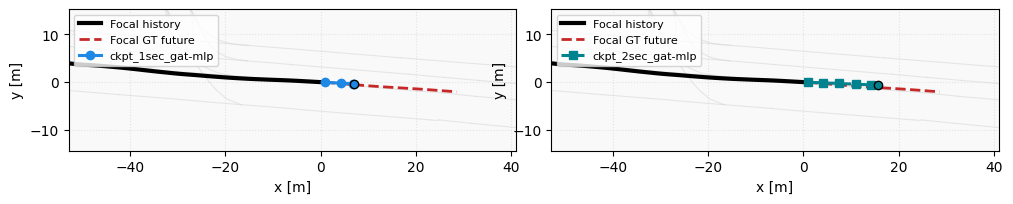


=== Scenario 1 ===
Scenario 00a5d0a7-3be4-4008-a77b-4eebe77b1480 | agents=9 lanes=58 | focal horizon=40/40 steps (~4.00s)

--- 2s models (4 ckpts) ---
Scenario 00a5d0a7-3be4-4008-a77b-4eebe77b1480 | agents=9 lanes=58 | focal horizon=40/40 steps (~4.00s)
ckpt_2sec_gat-lstm: pred shape=(1, 20, 2), focal_idx=2
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=2
ckpt_2sec_gcn_v2-lstm: pred shape=(1, 20, 2), focal_idx=2
ckpt_2sec_gcn_v2-mlp: pred shape=(1, 20, 2), focal_idx=2


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


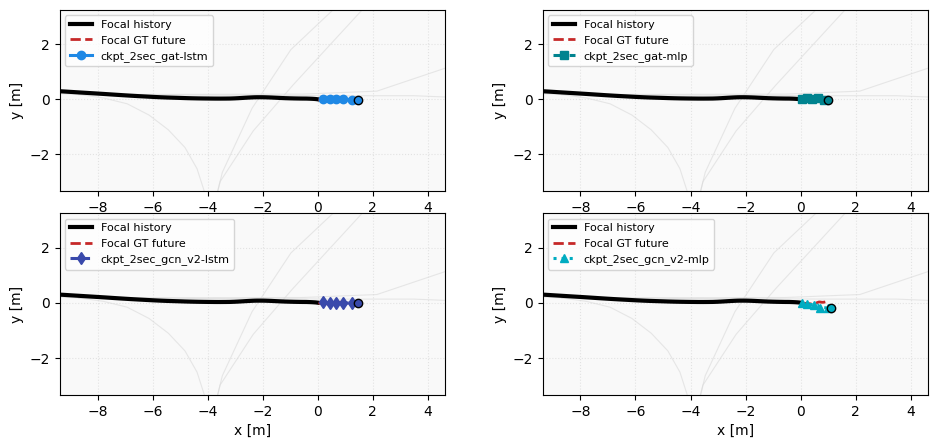


--- GAT-MLP 1s vs 2s ---
Scenario 00a5d0a7-3be4-4008-a77b-4eebe77b1480 | agents=9 lanes=58 | focal horizon=40/40 steps (~4.00s)
ckpt_1sec_gat-mlp: pred shape=(1, 10, 2), focal_idx=2
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=2


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


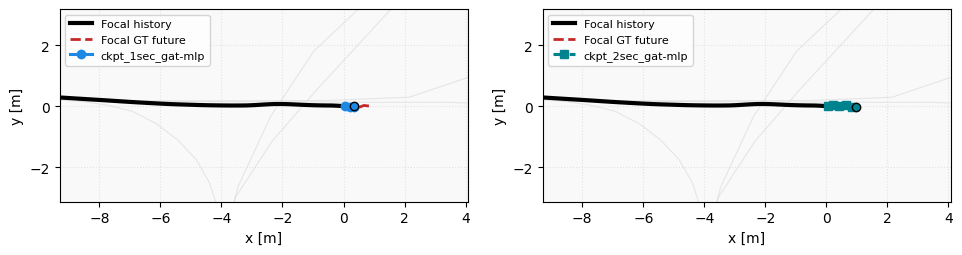


=== Scenario 2 ===
Scenario 00a8fc17-d464-47c6-95f9-4e99a9a6fe86 | agents=11 lanes=28 | focal horizon=40/40 steps (~4.00s)

--- 2s models (4 ckpts) ---
Scenario 00a8fc17-d464-47c6-95f9-4e99a9a6fe86 | agents=11 lanes=28 | focal horizon=40/40 steps (~4.00s)
ckpt_2sec_gat-lstm: pred shape=(1, 20, 2), focal_idx=4
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=4
ckpt_2sec_gcn_v2-lstm: pred shape=(1, 20, 2), focal_idx=4
ckpt_2sec_gcn_v2-mlp: pred shape=(1, 20, 2), focal_idx=4


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


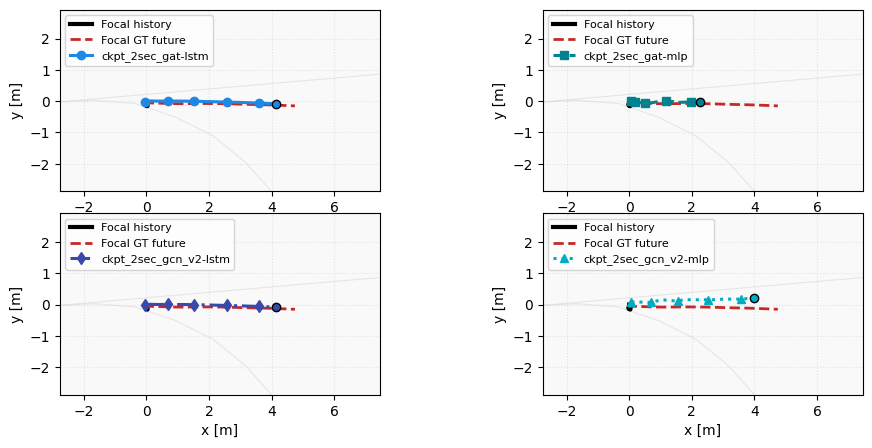


--- GAT-MLP 1s vs 2s ---
Scenario 00a8fc17-d464-47c6-95f9-4e99a9a6fe86 | agents=11 lanes=28 | focal horizon=40/40 steps (~4.00s)
ckpt_1sec_gat-mlp: pred shape=(1, 10, 2), focal_idx=4
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=4


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


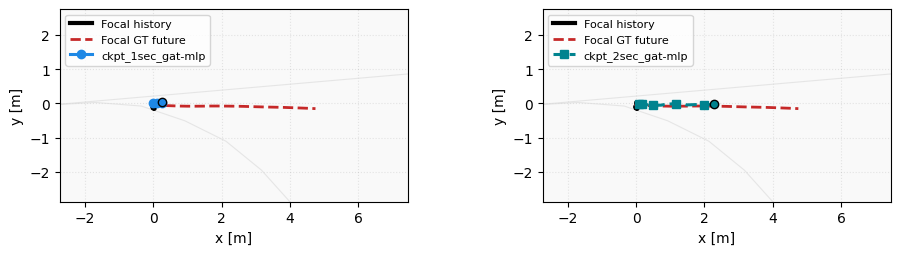


=== Scenario 3 ===
Scenario 0a09b183-3553-4c85-9a12-976409e4aeab | agents=10 lanes=53 | focal horizon=40/40 steps (~4.00s)

--- 2s models (4 ckpts) ---
Scenario 0a09b183-3553-4c85-9a12-976409e4aeab | agents=10 lanes=53 | focal horizon=40/40 steps (~4.00s)
ckpt_2sec_gat-lstm: pred shape=(1, 20, 2), focal_idx=0
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=0
ckpt_2sec_gcn_v2-lstm: pred shape=(1, 20, 2), focal_idx=0
ckpt_2sec_gcn_v2-mlp: pred shape=(1, 20, 2), focal_idx=0


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


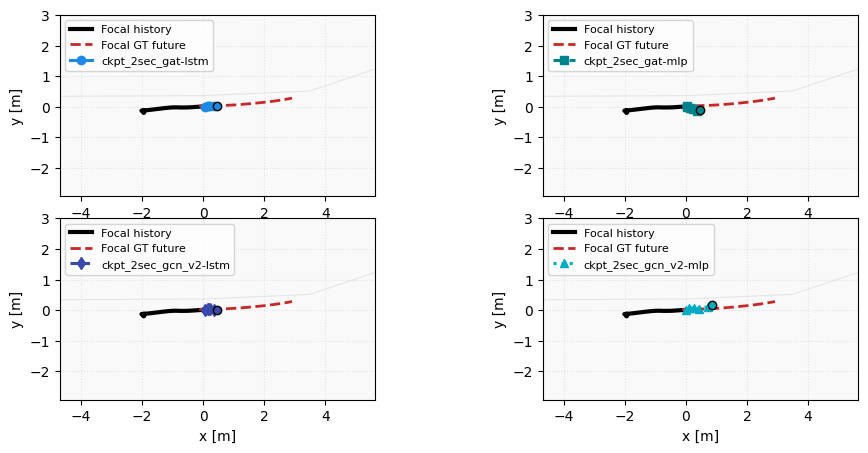


--- GAT-MLP 1s vs 2s ---
Scenario 0a09b183-3553-4c85-9a12-976409e4aeab | agents=10 lanes=53 | focal horizon=40/40 steps (~4.00s)
ckpt_1sec_gat-mlp: pred shape=(1, 10, 2), focal_idx=0
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=0


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


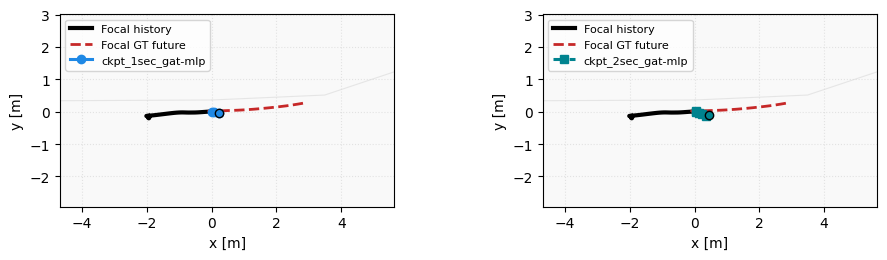


=== Scenario 4 ===
Scenario 0a0ef009-9d44-4399-99e6-50004d345f34 | agents=15 lanes=98 | focal horizon=40/40 steps (~4.00s)

--- 2s models (4 ckpts) ---
Scenario 0a0ef009-9d44-4399-99e6-50004d345f34 | agents=15 lanes=98 | focal horizon=40/40 steps (~4.00s)
ckpt_2sec_gat-lstm: pred shape=(1, 20, 2), focal_idx=0
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=0
ckpt_2sec_gcn_v2-lstm: pred shape=(1, 20, 2), focal_idx=0
ckpt_2sec_gcn_v2-mlp: pred shape=(1, 20, 2), focal_idx=0


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


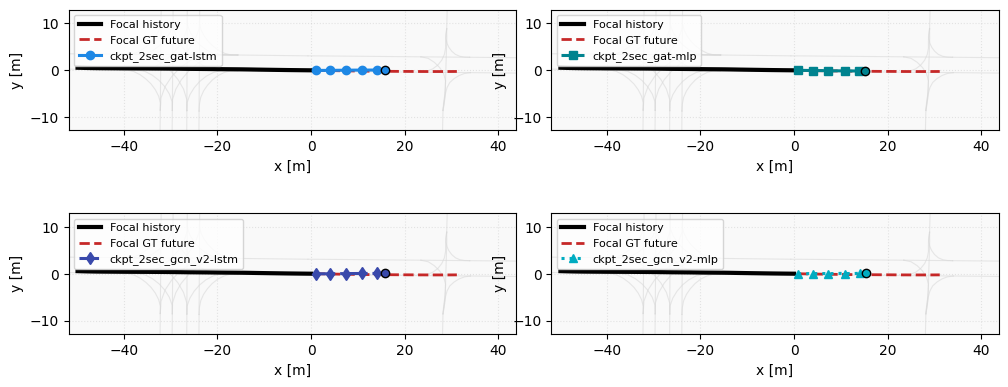


--- GAT-MLP 1s vs 2s ---
Scenario 0a0ef009-9d44-4399-99e6-50004d345f34 | agents=15 lanes=98 | focal horizon=40/40 steps (~4.00s)
ckpt_1sec_gat-mlp: pred shape=(1, 10, 2), focal_idx=0
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=0


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


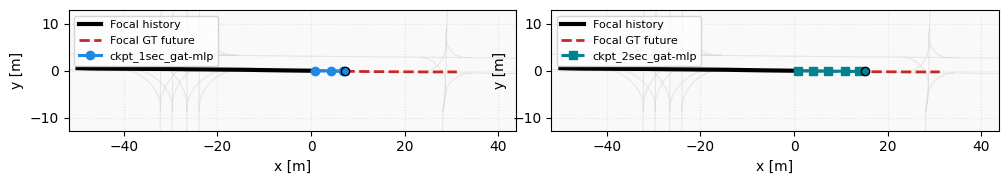


=== Scenario 5 ===
Scenario 0a1e6f0a-1817-4a98-b02e-db8c9327d151 | agents=1 lanes=71 | focal horizon=40/40 steps (~4.00s)

--- 2s models (4 ckpts) ---
Scenario 0a1e6f0a-1817-4a98-b02e-db8c9327d151 | agents=1 lanes=71 | focal horizon=40/40 steps (~4.00s)
ckpt_2sec_gat-lstm: pred shape=(1, 20, 2), focal_idx=0
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=0
ckpt_2sec_gcn_v2-lstm: pred shape=(1, 20, 2), focal_idx=0
ckpt_2sec_gcn_v2-mlp: pred shape=(1, 20, 2), focal_idx=0


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


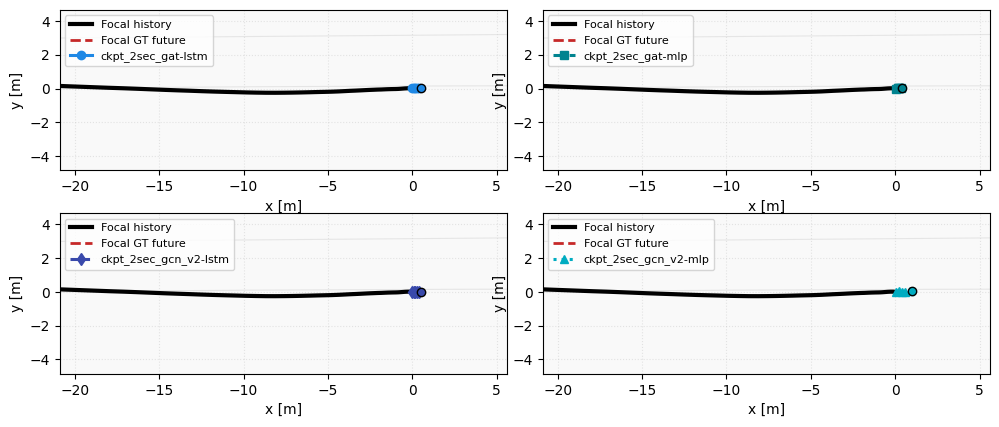


--- GAT-MLP 1s vs 2s ---
Scenario 0a1e6f0a-1817-4a98-b02e-db8c9327d151 | agents=1 lanes=71 | focal horizon=40/40 steps (~4.00s)
ckpt_1sec_gat-mlp: pred shape=(1, 10, 2), focal_idx=0
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=0


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


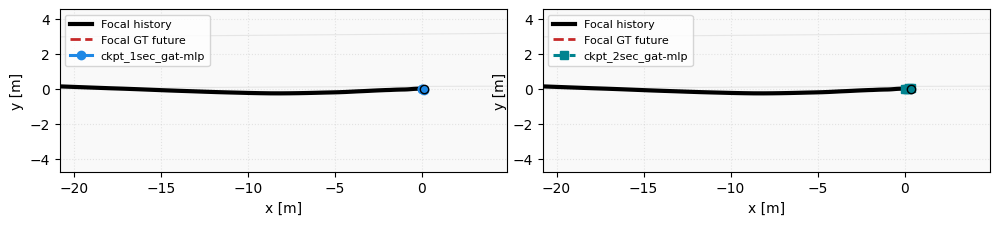


=== Scenario 6 ===
Scenario 0a2c19ce-b411-400a-ab56-8c40bc995ab1 | agents=8 lanes=145 | focal horizon=40/40 steps (~4.00s)

--- 2s models (4 ckpts) ---
Scenario 0a2c19ce-b411-400a-ab56-8c40bc995ab1 | agents=8 lanes=145 | focal horizon=40/40 steps (~4.00s)
ckpt_2sec_gat-lstm: pred shape=(1, 20, 2), focal_idx=1
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=1
ckpt_2sec_gcn_v2-lstm: pred shape=(1, 20, 2), focal_idx=1
ckpt_2sec_gcn_v2-mlp: pred shape=(1, 20, 2), focal_idx=1


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


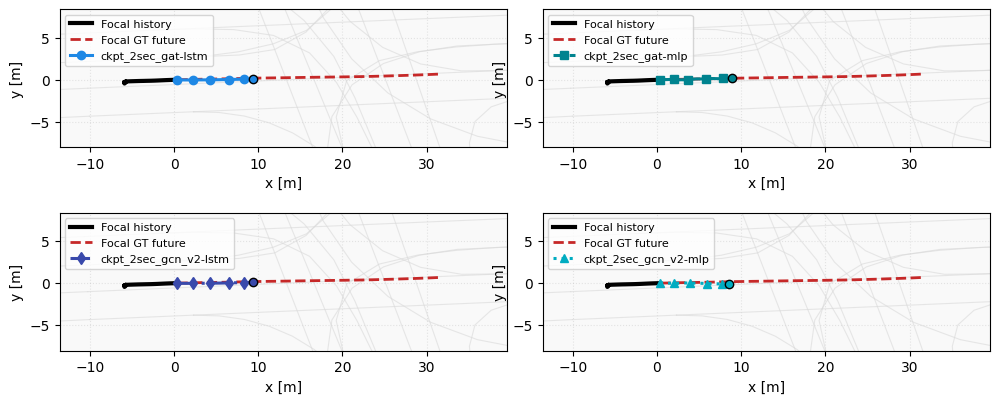


--- GAT-MLP 1s vs 2s ---
Scenario 0a2c19ce-b411-400a-ab56-8c40bc995ab1 | agents=8 lanes=145 | focal horizon=40/40 steps (~4.00s)
ckpt_1sec_gat-mlp: pred shape=(1, 10, 2), focal_idx=1
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=1


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


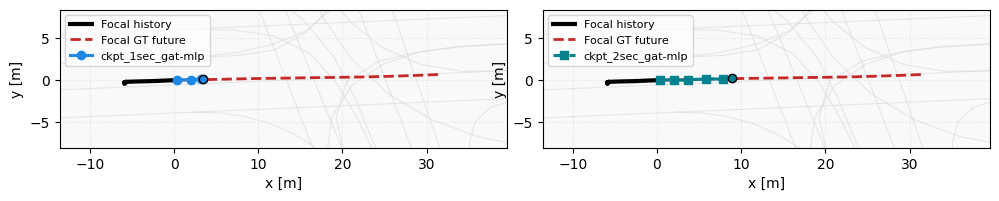


=== Scenario 7 ===
Scenario 0a3a794b-ce70-41af-80c3-8bbd828b7edf | agents=5 lanes=56 | focal horizon=40/40 steps (~4.00s)

--- 2s models (4 ckpts) ---
Scenario 0a3a794b-ce70-41af-80c3-8bbd828b7edf | agents=5 lanes=56 | focal horizon=40/40 steps (~4.00s)
ckpt_2sec_gat-lstm: pred shape=(1, 20, 2), focal_idx=3
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=3
ckpt_2sec_gcn_v2-lstm: pred shape=(1, 20, 2), focal_idx=3
ckpt_2sec_gcn_v2-mlp: pred shape=(1, 20, 2), focal_idx=3


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


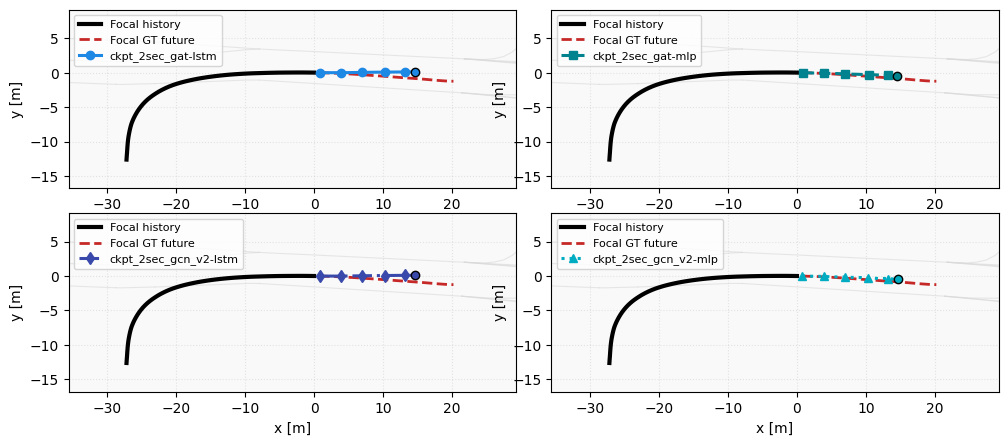


--- GAT-MLP 1s vs 2s ---
Scenario 0a3a794b-ce70-41af-80c3-8bbd828b7edf | agents=5 lanes=56 | focal horizon=40/40 steps (~4.00s)
ckpt_1sec_gat-mlp: pred shape=(1, 10, 2), focal_idx=3
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=3


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


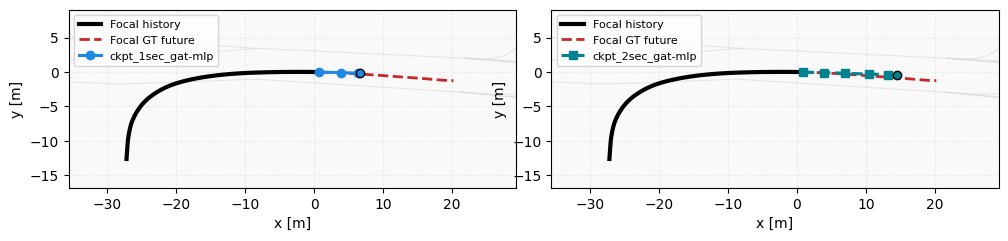


=== Scenario 8 ===
Scenario 0a3f4a4b-7c3c-4c29-ae6d-edcaee524113 | agents=10 lanes=69 | focal horizon=40/40 steps (~4.00s)

--- 2s models (4 ckpts) ---
Scenario 0a3f4a4b-7c3c-4c29-ae6d-edcaee524113 | agents=10 lanes=69 | focal horizon=40/40 steps (~4.00s)
ckpt_2sec_gat-lstm: pred shape=(1, 20, 2), focal_idx=1
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=1
ckpt_2sec_gcn_v2-lstm: pred shape=(1, 20, 2), focal_idx=1
ckpt_2sec_gcn_v2-mlp: pred shape=(1, 20, 2), focal_idx=1


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


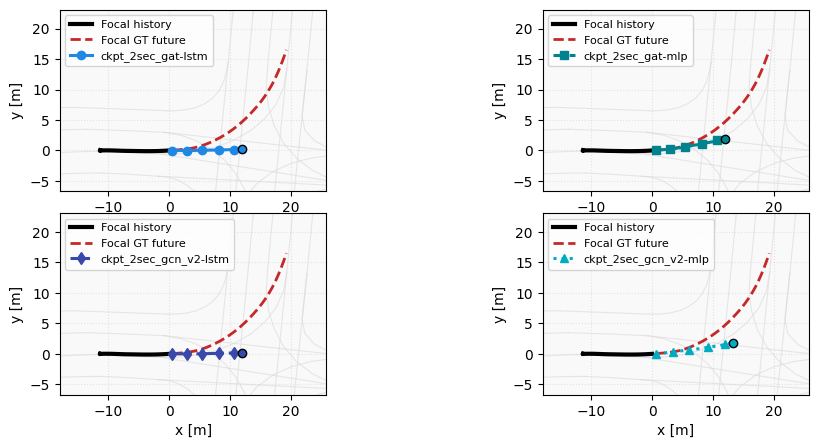


--- GAT-MLP 1s vs 2s ---
Scenario 0a3f4a4b-7c3c-4c29-ae6d-edcaee524113 | agents=10 lanes=69 | focal horizon=40/40 steps (~4.00s)
ckpt_1sec_gat-mlp: pred shape=(1, 10, 2), focal_idx=1
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=1


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


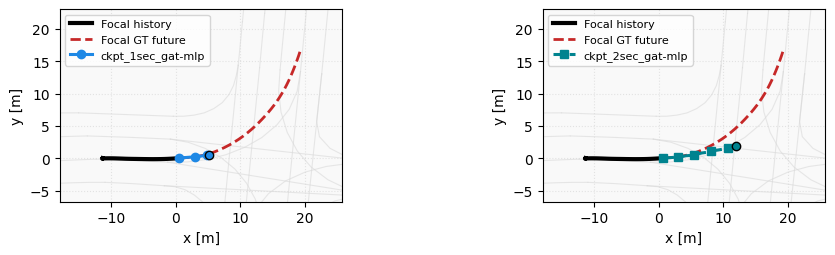


=== Scenario 9 ===
Scenario 0a3ffcba-a376-437c-96df-0bc7f9ee75e4 | agents=2 lanes=49 | focal horizon=40/40 steps (~4.00s)

--- 2s models (4 ckpts) ---
Scenario 0a3ffcba-a376-437c-96df-0bc7f9ee75e4 | agents=2 lanes=49 | focal horizon=40/40 steps (~4.00s)
ckpt_2sec_gat-lstm: pred shape=(1, 20, 2), focal_idx=1
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=1
ckpt_2sec_gcn_v2-lstm: pred shape=(1, 20, 2), focal_idx=1
ckpt_2sec_gcn_v2-mlp: pred shape=(1, 20, 2), focal_idx=1


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


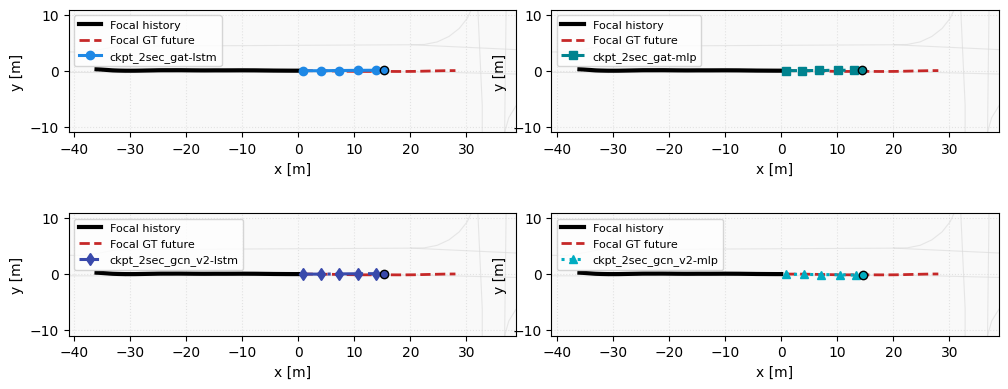


--- GAT-MLP 1s vs 2s ---
Scenario 0a3ffcba-a376-437c-96df-0bc7f9ee75e4 | agents=2 lanes=49 | focal horizon=40/40 steps (~4.00s)
ckpt_1sec_gat-mlp: pred shape=(1, 10, 2), focal_idx=1
ckpt_2sec_gat-mlp: pred shape=(1, 20, 2), focal_idx=1


/home/arian-sumak/code/DTU/GNNTrajectory/src/gnn_trajectory/visualize_predictions.py:355: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


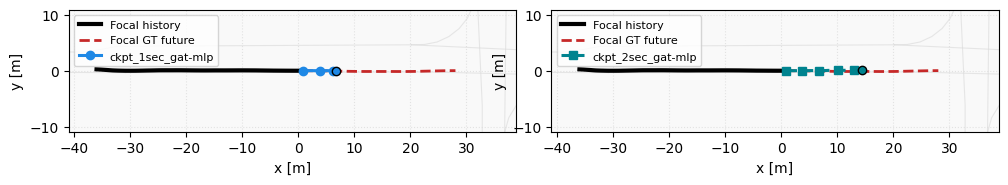

In [12]:

# Quick controls for what to visualize
GROUPS = {
    "2sec": [("2s models (4 ckpts)", models_2sec)],
    "gat-mlp": [("GAT-MLP 1s vs 2s", models_gat_mlp)],
    "both": [
        ("2s models (4 ckpts)", models_2sec),
        ("GAT-MLP 1s vs 2s", models_gat_mlp),
    ],
}
selected_groups = GROUPS.get(MODEL_GROUP, GROUPS["both"])

max_idx = len(ds) if SCENE_LIMIT is None else min(len(ds), SCENE_LIMIT)
indices = INDICES or list(range(START_IDX, min(max_idx, START_IDX + NUM_EXAMPLES)))

print(f"Planning to show indices: {indices} (max available: {max_idx})")
for idx in indices:
    if idx < 0 or idx >= max_idx:
        print(f"Index {idx} out of range (0..{max_idx-1})")
        continue

    print()  # spacing
    print(f"=== Scenario {idx} ===")
    summarize(ds[idx])

    for label, models in selected_groups:
        print(f"\n--- {label} ---")
        visualize_idx(idx, models, title_suffix=label)
